In [3]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from utils.masking import TriangularCausalMask, ProbMask
from models.encoder import Encoder, EncoderLayer, ConvLayer, EncoderStack
from models.decoder import Decoder, DecoderLayer
from models.attn import FullAttention, ProbAttention, AttentionLayer
from models.embed import DataEmbedding

debug = True

class Informer(nn.Module):
    def __init__(self, enc_in, dec_in, c_out, 
                factor=5, d_model=512, n_heads=8, e_layers=3, d_layers=2, d_ff=512, 
                dropout=0.0, attn='prob', embed='fixed', freq='h', activation='gelu', 
                output_attention = False, distil=True, mix=True,
                device=torch.device('cuda:0')):
        super(Informer, self).__init__()
        # self.pred_len = out_len
        self.attn = attn
        self.output_attention = output_attention

        # Encoding
        self.enc_embedding = DataEmbedding(enc_in, d_model, embed, freq, dropout, max_len=17280)
        self.dec_embedding = DataEmbedding(dec_in, d_model, embed, freq, dropout, max_len=17280)
        # Attention
        Attn = ProbAttention if attn=='prob' else FullAttention
        # Encoder
        self.encoder = Encoder(
            [
                EncoderLayer(
                    AttentionLayer(Attn(False, factor, attention_dropout=dropout, output_attention=output_attention), 
                                d_model, n_heads, mix=False),
                    d_model,
                    d_ff,
                    dropout=dropout,
                    activation=activation
                ) for l in range(e_layers)
            ],
            [
                ConvLayer(
                    d_model
                ) for l in range(e_layers-1)
            ] if distil else None,
            norm_layer=torch.nn.LayerNorm(d_model)
        )
        # Decoder
        self.decoder = Decoder(
            [
                DecoderLayer(
                    AttentionLayer(Attn(True, factor, attention_dropout=dropout, output_attention=False), 
                                d_model, n_heads, mix=mix),
                    AttentionLayer(FullAttention(False, factor, attention_dropout=dropout, output_attention=False), 
                                d_model, n_heads, mix=False),
                    d_model,
                    d_ff,
                    dropout=dropout,
                    activation=activation,
                )
                for l in range(d_layers)
            ],
            norm_layer=torch.nn.LayerNorm(d_model)
        )
        # self.end_conv1 = nn.Conv1d(in_channels=label_len+out_len, out_channels=out_len, kernel_size=1, bias=True)
        # self.end_conv2 = nn.Conv1d(in_channels=d_model, out_channels=c_out, kernel_size=1, bias=True)
        self.projection = nn.Linear(d_model, c_out, bias=True)
        self.finalact = nn.Softmax(dim=-1)

    def forward(self, x_enc, x_dec, 
                enc_self_mask=None, dec_self_mask=None, dec_enc_mask=None):
        if debug:
            print(f"Input x_enc: {x_enc.shape}")
        enc_out = self.enc_embedding(x_enc)
        if debug:
            print(f"enc_embedding: {enc_out.shape}")
        enc_out, attns = self.encoder(enc_out, attn_mask=enc_self_mask)
        if debug:
            print(f"encoder: {enc_out.shape}")
        
        if debug:
            print(f"Input x_dec: {x_dec.shape}")
        dec_out = self.dec_embedding(x_dec)
        if debug:
            print(f"dec_embedding: {dec_out.shape}")
        dec_out = self.decoder(dec_out, enc_out, x_mask=dec_self_mask, cross_mask=dec_enc_mask)
        if debug:
            print(f"decoder: {dec_out.shape}")
        dec_out = self.projection(dec_out)
        if debug:
            print(f"projection: {dec_out.shape}")
        dec_out = self.finalact(dec_out)
        if self.output_attention:
            return dec_out, attns  # 返回整个dec_out和注意力权重（如果需要）
        else:
            return dec_out  # 返回整个dec_out

In [5]:
args = dotdict()
args.model = 'informer' # model of experiment, options: [informer, informerstack, informerlight(TBD)]
args.freq = 'h' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.checkpoints = './informer_checkpoints' # location of model checkpoints
args.factor = 3 # probsparse attn factor
args.e_layers = 2 # num of encoder layers
args.d_layers = 1 # num of decoder layers
args.dropout = 0.01 # dropout
args.attn = 'prob' # attention used in encoder, options:[prob, full]
args.embed = 'learned' # time features encoding, options:[timeF, fixed, learned]
args.activation = 'gelu' # activation
args.distil = True # whether to use distilling in encoder
args.output_attention = False # whether to output attention in ecoder
args.mix = True
args.padding = -1
args.freq = 'h'

enc_in = 12
dec_in = enc_in
c_out = 2
n_heads = 8
d_model = 64
d_ff = 128
model = Informer(
    enc_in,
    dec_in, 
    c_out, 
    args.factor,
    d_model, 
    n_heads, 
    args.e_layers,
    args.d_layers, 
    d_ff,
    args.dropout, 
    args.attn,
    args.embed,
    args.freq,
    args.activation,
    args.output_attention,
    args.distil,
    args.mix,
    'cuda'
).float()
model_name = f'{d_model}d_modelx{d_ff}d_ffx{n_heads}heads_{args.e_layers}enc_layers_{args.d_layers}dec_layers'
print(f"Total parm of Model: {sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6}M")
# torch.Size([1, 96, 7]) torch.Size([1, 96, 4]) torch.Size([1, 72, 7]) torch.Size([1, 72, 4])
# print(batch_x.shape, batch_x_mark.shape, dec_inp.shape, batch_y_mark.shape)

print(model(torch.rand(1, 4320, enc_in), torch.rand(1, 4320, enc_in)).shape)
debug = False

Total parm of Model: 0.144514M
Input x_enc: torch.Size([1, 4320, 12])
enc_embedding: torch.Size([1, 4320, 64])
encoder: torch.Size([1, 2160, 64])
Input x_dec: torch.Size([1, 4320, 12])
dec_embedding: torch.Size([1, 4320, 64])
decoder: torch.Size([1, 4320, 64])
projection: torch.Size([1, 4320, 2])
torch.Size([1, 4320, 2])


In [4]:
model_name

'64d_modelx128d_ffx8heads_2enc_layers_1dec_layers'

In [5]:
from pathlib import Path
import pickle
import numpy as np
from matplotlib import pyplot as plt

# DATA_ROOT = Path('/home/ljb/data')

# x_train_path = DATA_ROOT / 'X_train_notime_little.pkl'
# y_train_path = DATA_ROOT / 'y_train_notime_little.pkl'

In [6]:
# with open(y_train_path, 'rb') as f:
#     y_train_all=torch.from_numpy(pickle.load(f))[:,::6]
# print(np.unique(y_train_all))
# with open(x_train_path, 'rb') as f:
#     x_train_all=torch.from_numpy(pickle.load(f))[:,::6]

In [7]:
with open('/home/ljb/all_data_new.pkl', 'rb') as f:
    arr = pickle.load(f)
    print(arr[0].shape)

(252457, 13)


In [8]:
downsample_arr = []
for ts in arr:
    downsample_arr.append(ts[::4])

In [9]:
class TimeSeries:
    def __init__(self, raw) -> None:
        raw = torch.from_numpy(raw).float()
        self.x = raw[:, :-1]
        self.y = F.one_hot(raw[:, -1:].long(), 2)[:,0].float()
        pass
    
    

In [10]:
all_arr = []
skip = 0
for i in downsample_arr:
    if len(i) < 1900:
        print(i.shape)
        skip += 1
        continue
    all_arr.append(TimeSeries(i))
print(skip)

(1654, 13)
(901, 13)
(1786, 13)
(1777, 13)
(1324, 13)
(901, 13)
(1858, 13)
7


In [11]:
# from sklearn.preprocessing import RobustScaler
# import joblib
# Path(f'{model_name}').mkdir(exist_ok=True)

# scaler = RobustScaler(quantile_range=(1, 99))
# shape = x_train_all.shape
# x_train_all = x_train_all.reshape(-1, enc_in)
# scaler.fit(x_train_all)
# joblib.dump(scaler, f"{model_name}/robust_scaler.pkl")
# x_train_all = scaler.transform(x_train_all)
# x_train_all = torch.from_numpy(x_train_all.reshape(shape))

In [12]:
# # onehot 
# y_train_all_onehot = torch.nn.functional.one_hot(y_train_all.long(), 2)[:,:,0].float()
# # y_train_all_onehot = label_smoothing(y_train_all_onehot)
# print(y_train_all_onehot.shape)
# from sklearn.model_selection import train_test_split
# x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all_onehot, test_size=0.2, random_state=42)
import random

train_arr = random.sample(all_arr, int(len(all_arr) * 0.8))
val_arr = list(set(all_arr) - set(train_arr))

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.len = x.shape[0]
        self.length = x.shape[1]
        self.num_feat = x.shape[2]
        

    def aug(self,x,y):
        if torch.rand(1) < 0.5:
            x = torch.flip(x, dims=[0])
            y = torch.flip(y, dims=[0])
        if torch.rand(1) < 0.2:
            return x, y
        clip_length = int((torch.rand(1) * (1.0 - 0.2) + 0.2) * self.length)
        pad_length = self.length - clip_length
        # print(pad_length, clip_length)
        x = x[:clip_length]
        y = y[:clip_length]
        
        x = torch.cat([x, -torch.ones(pad_length, self.num_feat)], dim=0)
        y = torch.cat([y, torch.cat([torch.zeros(pad_length, 1), torch.ones(pad_length, 1)], dim=1)], dim=0)
        return x, y
        
    def __getitem__(self, index):
        return self.aug(self.x[index], self.y[index])
    
    def __len__(self):
        return self.len
    
class newMyDataset(torch.utils.data.Dataset):
    def __init__(self, train_arr):
        self.train_arr = train_arr
        self.len = len(train_arr)
        # self.featss = train_arr[0].x.shape[-1]

    def aug(self,ts):
        temp_x = ts.x
        temp_y = ts.y
        
        if torch.rand(1) < 0.5:
            temp_x = torch.flip(temp_x, dims=[0])
            temp_y = torch.flip(temp_y, dims=[0])
            
        if temp_x.shape[0] >= 4320:
        
            if torch.rand(1) < 0.2:
                start_index = int(torch.rand(1) * (len(temp_y)-4320))
                temp_x = temp_x[start_index:]
                temp_y = temp_y[start_index:]
            d = int(len(temp_x) / 4320)
            # print(4320*int(len(temp_x) / 4320))
            try:
                temp_x = temp_x[:4320*d].reshape(-1, 4320, 12)
                temp_y = temp_y[:4320*d].reshape(-1, 4320, 2)
                max_batch = 4
                if d > max_batch:
                    # random sample max_batch data
                    radnom_index = random.sample(range(d), max_batch)
                    # print(radnom_index)
                    temp_x = temp_x[radnom_index]
                    temp_y = temp_y[radnom_index]
                    # print(temp_x.shape)
            except Exception as e:
                print(e)
                print(temp_x.shape)
                print(temp_y.shape)
                # print(d)
                # print(4320*d)
                # print(len(temp_x))
                # print(len(temp_y))
                # print(4320*d - len(temp_x))
                # print(4320*d - len(temp_y))
                # print(4320*d - len(temp_x) == 4320*d - len(temp_y))
                raise e
        else:
            temp_x = temp_x.unsqueeze(0)
            temp_y = temp_y.unsqueeze(0)
            
        return temp_x, temp_y
        
    def __getitem__(self, index):
        return self.aug(self.train_arr[index])
    
    def __len__(self):
        return self.len

# print(x_val.shape)
# print(y_val.shape)
ds = newMyDataset(train_arr)
dl = torch.utils.data.DataLoader(ds, batch_size=1, shuffle=True, num_workers=24)
ds_val = newMyDataset(val_arr)
dl_val = torch.utils.data.DataLoader(ds_val, batch_size=1, shuffle=True, num_workers=24)
for x,y in dl:
    print(x.shape, y.shape)
    break

torch.Size([1, 4, 4320, 12]) torch.Size([1, 4, 4320, 2])


In [13]:

def draw_one_batch(x, y, y_pred, title=None):
    x, y, y_pred = x.detach().cpu().numpy(), y.detach().cpu().numpy(), y_pred.detach().cpu().numpy()
    # y_pred = F.softmax(torch.from_numpy(y_pred), dim=-1).numpy()
    x = x[0,:,1]
    y = y[0,:,1]
    y_pred = y_pred[0,:,1]
    if title is not None:
        plt.title(title)
    plt.plot(x, label='x')
    plt.plot(y, label='y')
    plt.plot(y_pred, label='y_pred')
    plt.legend()
    plt.show()
    
# test_batch = ds[0]
# draw_one_batch(test_batch, test_batch, test_batch)

In [14]:
# model.load_state_dict(torch.load('64d_modelx128d_ffx8heads_2enc_layers_1dec_layers/model_100.pth'))

In [15]:
def split_tensor(tensor, max_length=4320, min_length=2160):
    """
    Fixed version of the function to split a 2D tensor along the first dimension into sub-tensors of lengths 
    not exceeding max_length and not less than min_length. Averages the lengths of the last two sub-tensors if possible.
    
    Parameters:
    - tensor (torch.Tensor): The input tensor of shape (length, 12).
    - max_length (int): The maximum length for each sub-tensor.
    - min_length (int): The minimum length for each sub-tensor.
    
    Returns:
    - List[torch.Tensor]: A list of sub-tensors.
    """
    try:
        # Get the total length of the tensor
        length = tensor.shape[0]
        if length <= max_length:
            return []
        # Initialize the list to hold sub-tensor lengths
        sub_lengths = []
        
        while length > 0:
            if length >= max_length:
                sub_lengths.append(max_length)
                length -= max_length
            elif length >= min_length:
                sub_lengths.append(length)
                length = 0  # all the tensor length has been allocated
            else:
                # If the remaining length is less than the min_length, borrow some length from the last added sub-tensor
                # (which has max_length) to make it at least min_length
                last_length = sub_lengths.pop()
                sub_lengths.append(min_length)
                remaining_last_length = last_length - (min_length - length)
                if remaining_last_length >= min_length:
                    sub_lengths.append(remaining_last_length)
                length = 0  # all the tensor length has been allocated
        
        # Average the last two sub-tensors if their total length is greater than 2 * min_length
        if len(sub_lengths) > 1 and sum(sub_lengths[-2:]) > 2 * min_length:
            last_two_sum = sub_lengths.pop() + sub_lengths.pop()
            avg_length1 = last_two_sum // 2
            avg_length2 = last_two_sum - avg_length1  # Ensure the two lengths sum up to the original sum
            sub_lengths.extend([avg_length1, avg_length2])
        
        # Split the tensor
        sub_tensors = torch.split(tensor, sub_lengths, dim=0)
    except Exception as e:
        print(tensor.shape)
        raise e
    ret = []
    shape_dict = {}
    for sub in sub_tensors:
        length = sub.shape[0]
        if length in shape_dict.keys():
            shape_dict[length].append(sub.unsqueeze(0))
        else:
            shape_dict[length] = [sub.unsqueeze(0)]
    for k, v in shape_dict.items():
        ret.append(torch.cat(v, dim=0))
    return ret


for i, _ in zip(split_tensor(torch.rand(16541, 2)), split_tensor(torch.rand(16541, 2))):
    print(i.shape)

torch.Size([2, 4320, 2])
torch.Size([1, 3950, 2])
torch.Size([1, 3951, 2])


In [16]:
Path(model_name).mkdir(exist_ok=True)

>>>>>>>>>>>>>>>>>>>>Epoch 1 Train Loss: 0.6391208350887225>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 2 Train Loss: 0.612026702705592>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 3 Train Loss: 0.6234467667375554>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 4 Train Loss: 0.5979215626867628>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 5 Train Loss: 0.5789409858709105>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 6 Train Loss: 0.5723245877794021>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 7 Train Loss: 0.5687564700670297>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 8 Train Loss: 0.5770275814748314>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 9 Train Loss: 0.5616003286930055>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 10 Train Loss: 0.5668491998583708>>>>>>>>>>>>>>>>>>>>


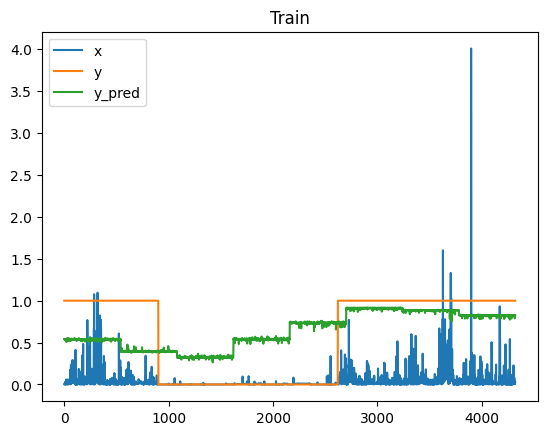

>>>>>>>>>>>>>>>>>>>>Val Loss: 0.5526117307084207>>>>>>>>>>>>>>>>>>>>


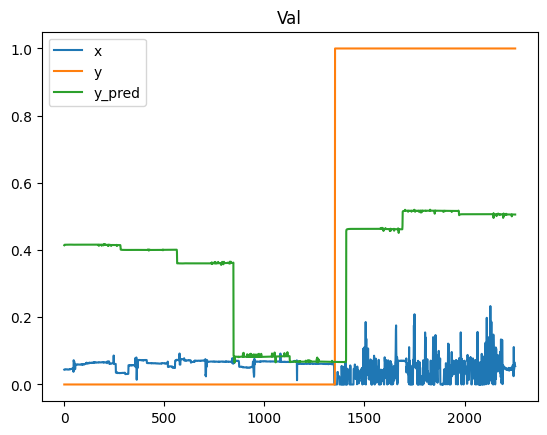

>>>>>>>>>>>>>>>>>>>>Epoch 11 Train Loss: 0.5573188633355893>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 12 Train Loss: 0.5679864698087872>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 13 Train Loss: 0.5609197419801738>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 14 Train Loss: 0.5548334315047383>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 15 Train Loss: 0.5577176080555467>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 16 Train Loss: 0.5688175429194994>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 17 Train Loss: 0.5676742362541338>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 18 Train Loss: 0.5481174457782518>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 19 Train Loss: 0.5580713150597351>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 20 Train Loss: 0.537456186227286>>>>>>>>>>>>>>>>>>>>


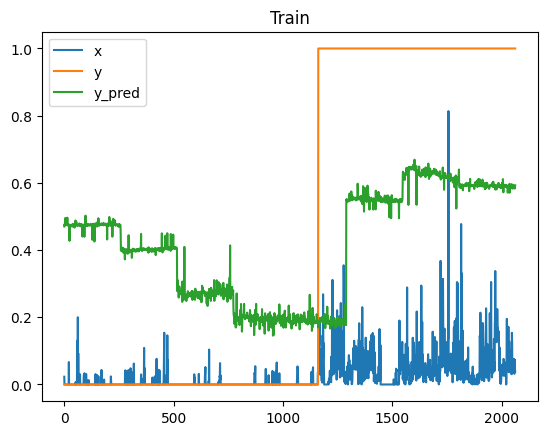

>>>>>>>>>>>>>>>>>>>>Val Loss: 0.5851064454053194>>>>>>>>>>>>>>>>>>>>


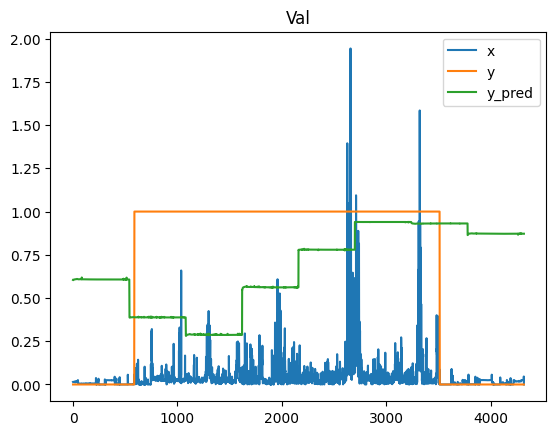

>>>>>>>>>>>>>>>>>>>>Epoch 21 Train Loss: 0.5631501319426722>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 22 Train Loss: 0.54379242841662>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 23 Train Loss: 0.5527579391986532>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 24 Train Loss: 0.5463661886108128>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 25 Train Loss: 0.4949743187988102>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 26 Train Loss: 0.3739086221939314>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 27 Train Loss: 0.31130149113926>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 28 Train Loss: 0.31550142511496615>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 29 Train Loss: 0.28198346075550035>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 30 Train Loss: 0.23939131043007644>>>>>>>>>>>>>>>>>>>>


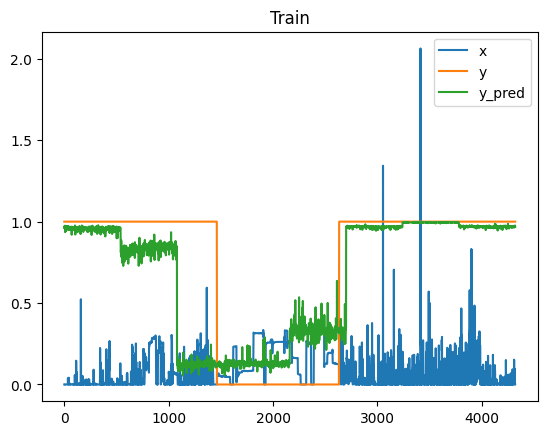

>>>>>>>>>>>>>>>>>>>>Val Loss: 0.44420813049637636>>>>>>>>>>>>>>>>>>>>


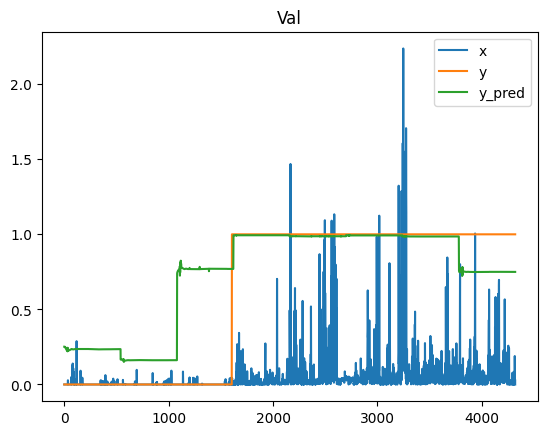

>>>>>>>>>>>>>>>>>>>>Epoch 31 Train Loss: 0.23104786787060538>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 32 Train Loss: 0.19557290470259775>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 33 Train Loss: 0.18674433504494045>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 34 Train Loss: 0.1932823923407498>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 35 Train Loss: 0.18008532665755722>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 36 Train Loss: 0.1757441745488234>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 37 Train Loss: 0.18025041597889963>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 38 Train Loss: 0.17082359627489851>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 39 Train Loss: 0.1667913574503731>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 40 Train Loss: 0.16468102208941088>>>>>>>>>>>>>>>>>>>>


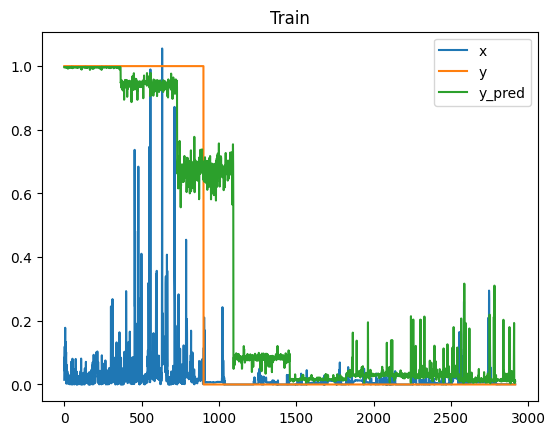

>>>>>>>>>>>>>>>>>>>>Val Loss: 0.4541170310996871>>>>>>>>>>>>>>>>>>>>


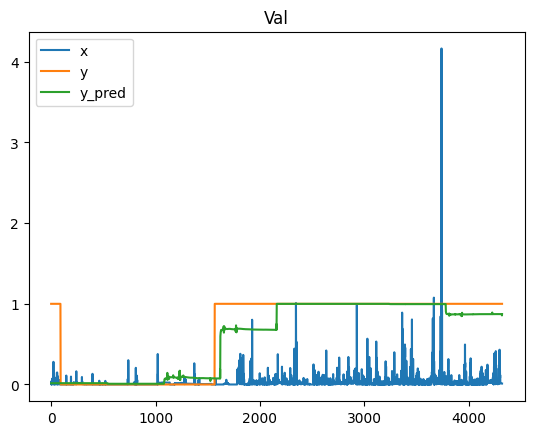

>>>>>>>>>>>>>>>>>>>>Epoch 41 Train Loss: 0.18661700491212493>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 42 Train Loss: 0.17642892739823135>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 43 Train Loss: 0.16078227042665638>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 44 Train Loss: 0.15964087612226233>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 45 Train Loss: 0.1677900366806881>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 46 Train Loss: 0.16435616943563358>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 47 Train Loss: 0.16490285798564067>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 48 Train Loss: 0.15282699938384448>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 49 Train Loss: 0.16227355413853894>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 50 Train Loss: 0.1564239332606147>>>>>>>>>>>>>>>>>>>>


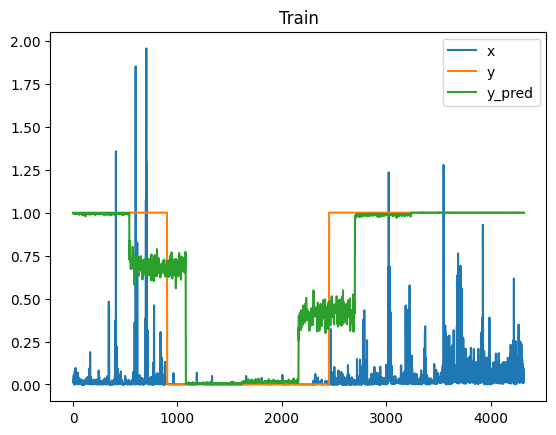

>>>>>>>>>>>>>>>>>>>>Val Loss: 0.2785924306807627>>>>>>>>>>>>>>>>>>>>


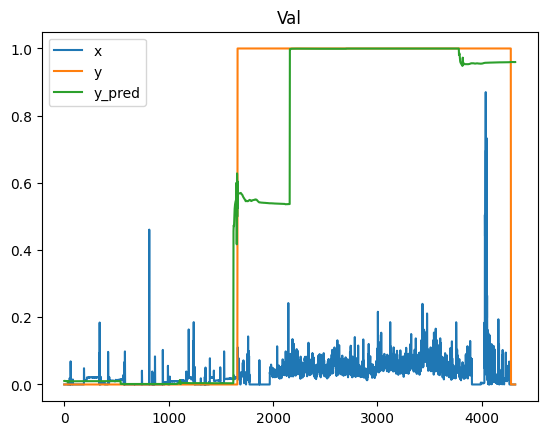

>>>>>>>>>>>>>>>>>>>>Epoch 51 Train Loss: 0.15338265047106542>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 52 Train Loss: 0.15543961902497597>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 53 Train Loss: 0.14935057913087266>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 54 Train Loss: 0.15347604285532362>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 55 Train Loss: 0.15047293093463052>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 56 Train Loss: 0.14834429626487153>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 57 Train Loss: 0.1534401491827791>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 58 Train Loss: 0.15031328893869028>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 59 Train Loss: 0.15294746257321848>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 60 Train Loss: 0.14942152760994412>>>>>>>>>>>>>>>>>>>>


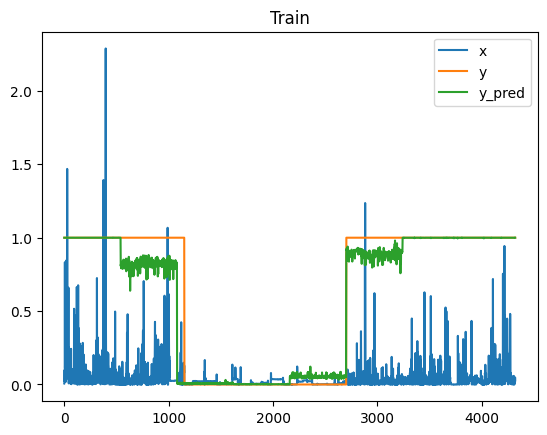

>>>>>>>>>>>>>>>>>>>>Val Loss: 0.23117110454512915>>>>>>>>>>>>>>>>>>>>


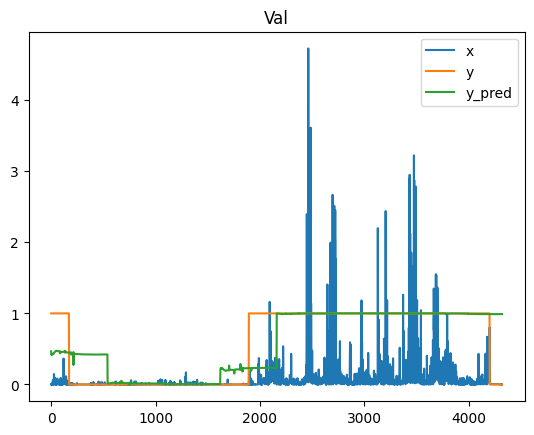

>>>>>>>>>>>>>>>>>>>>Epoch 61 Train Loss: 0.14517251768233452>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 62 Train Loss: 0.15002343367835266>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 63 Train Loss: 0.14943181516355952>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 64 Train Loss: 0.15595008517595835>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 65 Train Loss: 0.14367266646059026>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 66 Train Loss: 0.13856536769906985>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 67 Train Loss: 0.1458424283066432>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 68 Train Loss: 0.13922382571561093>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 69 Train Loss: 0.14102339447474183>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 70 Train Loss: 0.1439412385010788>>>>>>>>>>>>>>>>>>>>


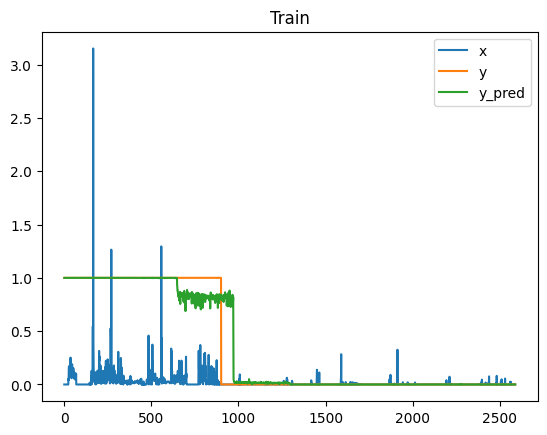

>>>>>>>>>>>>>>>>>>>>Val Loss: 0.19873637125919794>>>>>>>>>>>>>>>>>>>>


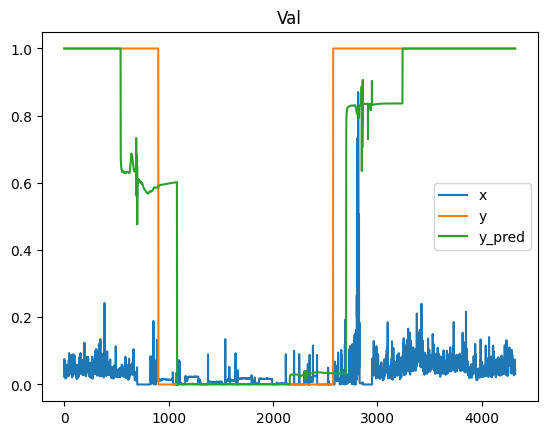

>>>>>>>>>>>>>>>>>>>>Epoch 71 Train Loss: 0.14381064123861964>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 72 Train Loss: 0.13834835189947012>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 73 Train Loss: 0.13597137104870033>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 74 Train Loss: 0.1401512897117582>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 75 Train Loss: 0.1376500240582508>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 76 Train Loss: 0.13937317079823328>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 77 Train Loss: 0.13646674585741392>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 78 Train Loss: 0.13622236030887733>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 79 Train Loss: 0.13860729036427277>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 80 Train Loss: 0.13495486845117555>>>>>>>>>>>>>>>>>>>>


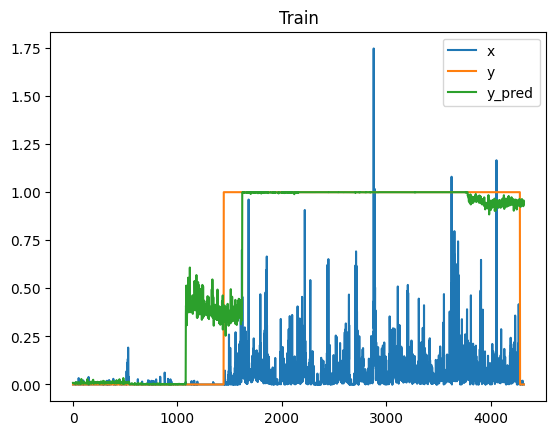

>>>>>>>>>>>>>>>>>>>>Val Loss: 0.20051383790169053>>>>>>>>>>>>>>>>>>>>


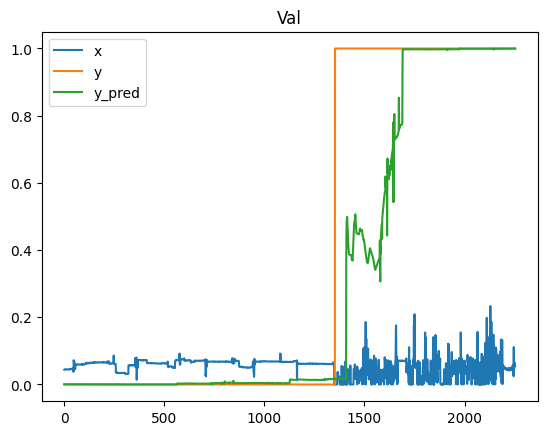

>>>>>>>>>>>>>>>>>>>>Epoch 81 Train Loss: 0.14010186186292692>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 82 Train Loss: 0.13605321973076023>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 83 Train Loss: 0.133938090110666>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 84 Train Loss: 0.13600970938043838>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 85 Train Loss: 0.13188429013602507>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 86 Train Loss: 0.12964130075015629>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 87 Train Loss: 0.1346169448781208>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 88 Train Loss: 0.13481411295308376>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 89 Train Loss: 0.13468437496172317>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 90 Train Loss: 0.1301859201033977>>>>>>>>>>>>>>>>>>>>


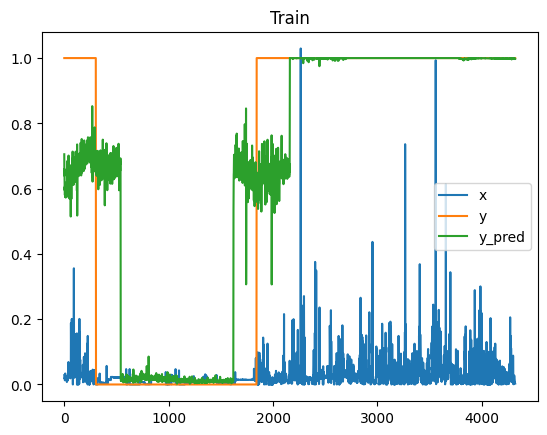

>>>>>>>>>>>>>>>>>>>>Val Loss: 0.19037679642552638>>>>>>>>>>>>>>>>>>>>


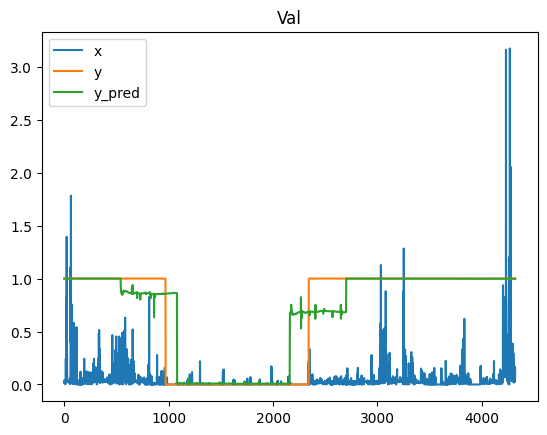

>>>>>>>>>>>>>>>>>>>>Epoch 91 Train Loss: 0.13126511827125545>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 92 Train Loss: 0.12883031023970148>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 93 Train Loss: 0.131502933335453>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 94 Train Loss: 0.13278756294606858>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 95 Train Loss: 0.1298861166805515>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 96 Train Loss: 0.13032939133275437>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 97 Train Loss: 0.13426311546132225>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 98 Train Loss: 0.12660464732737894>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 99 Train Loss: 0.13324206205167147>>>>>>>>>>>>>>>>>>>>
>>>>>>>>>>>>>>>>>>>>Epoch 100 Train Loss: 0.12893500275223474>>>>>>>>>>>>>>>>>>>>


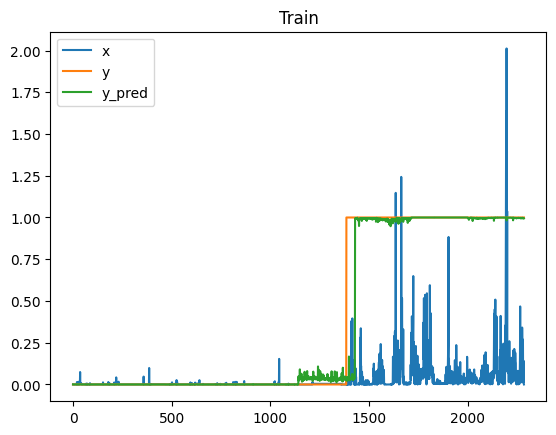

>>>>>>>>>>>>>>>>>>>>Val Loss: 0.21916637441697923>>>>>>>>>>>>>>>>>>>>


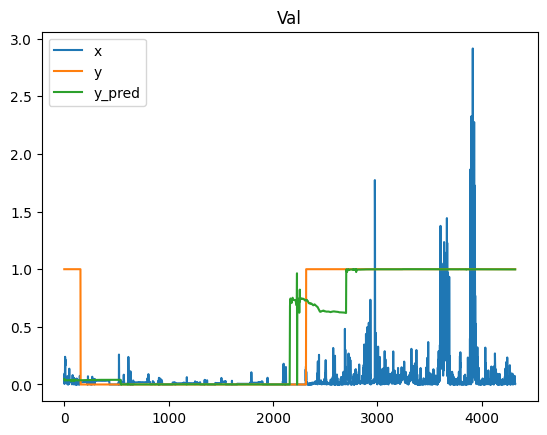

In [17]:
from tqdm import tqdm

val_pre_epoch = 10

def train_one_epoch(dl, model, loss_fn, optimizer, e, scheduler=None):
    model.train()
    model = model.cuda()
    # for x, y in dl:
    #     x = x.float().cuda()
    #     y = y.float().cuda()
    #     y_pred = model(x, x)
    #     loss = F.cross_entropy(y_pred, y)
    #     print(">"*20+str(loss.item())+">"*20)
    #     loss.backward()
    train_loss = []
    # y_pred = None
    for i, (x, y) in enumerate(dl):
        if len(x.shape) == 4:
            x = x[0]
            y = y[0]
        # print(x.shape, y.shape)
        # try:
        #     for x, y in zip(split_tensor(x), split_tensor(y)):
        #         x = x.float().cuda()
        #         y = y.float().cuda()
        #         print(x.shape)
                
        #         optimizer.zero_grad()
        #         y_pred = model(x, x)
        #         loss = loss_fn(y_pred, y)
        #         loss.backward()
        #         train_loss.append(loss.item())
        #         optimizer.step()
        # except Exception as e:
        #     print(x.shape, y.shape)
        #     raise e
        try:
            x = x.float().cuda()
            y = y.float().cuda()
            optimizer.zero_grad()
            y_pred = model(x, x)
            loss = loss_fn(y_pred, y)
            loss.backward()
            train_loss.append(loss.item())
            optimizer.step()
            torch.cuda.empty_cache()
        except Exception as e:
            print(x.shape, y.shape)
            raise e
        
    if scheduler is not None:
        scheduler.step()
        # break
    train_loss = np.average(train_loss)
    print(">"*20+f"Epoch {e} Train Loss: "+str(train_loss)+">"*20)
    if e % val_pre_epoch == 0:
        torch.save(model.state_dict(), f'./{model_name}/model_{e}.pth')
        draw_one_batch(x, y, y_pred, title=f"Train")

def val_one_epoch(dl, model):
    model.eval()
    model = model.cuda()
    val_loss = []
    with torch.no_grad():
        for i, (x, y) in enumerate(dl):
            if len(x.shape) == 4:
                x = x[0]
                y = y[0]
            x = x.float().cuda()
            y = y.float().cuda()
            y_pred = model(x, x)
            loss = loss_fn(y_pred, y)
            val_loss.append(loss.item())
            # for x, y in zip(split_tensor(x), split_tensor(y)):
            #     x = x.float().cuda()
            #     y = y.float().cuda()
            #     y_pred = model(x, x)
            #     loss = loss_fn(y_pred, y)
            #     val_loss.append(loss.item())
            
    val_loss = np.average(val_loss)
    print(">"*20+"Val Loss: "+str(val_loss)+">"*20)
    draw_one_batch(x, y, y_pred, title=f"Val")
    torch.cuda.empty_cache()

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=100, eta_min=1e-4)
# loss_fn = torch.nn.MSELoss()
loss_fn = torch.nn.BCELoss()
for i in range(1, 101):
    train_one_epoch(dl, model, loss_fn, optimizer, i, scheduler)
    if i % val_pre_epoch == 0:
        val_one_epoch(dl_val, model)

In [18]:
def draw_one_batch_and_attn(x, y, y_pred, attn, title=None):
    x, y, y_pred, attn = x.detach().cpu().numpy(), y.detach().cpu().numpy(), y_pred.detach().cpu().numpy(), attn.detach().cpu().numpy()
    x = x[0,:,1]
    y = y[0,:,1]
    y_pred = y_pred[0,:,1]
    attn = attn[0,:,:]
    
    if title is not None:
        plt.title(title)
    plt.plot(x, label='x')
    plt.plot(y, label='y')
    plt.plot(y_pred, label='y_pred')
    
    # draw attn
    for i in range(attn.shape[0]):
        plt.plot(attn[i,:], label=f'attn_{i}')
        break
    
    plt.legend()
    plt.show()


def check_attention(model, dl):
    model.eval()
    model.output_attention = True
    model.encoder.attn_layers[0].attention.inner_attention.output_attention = True
    model = model.cuda()
    for i, (x, y) in enumerate(dl):
        torch.cuda.empty_cache()
        x = x.reshape(1, *x.shape)
        y = y.reshape(1, *y.shape)
        x = x.float().cuda()
        y = y.float().cuda()
        y_pred, attns = model(x, x)
        print(attns[0].shape)
        # draw_one_batch_and_attn(x, y, y_pred, attns[0], title=f"Val")
        break
    model.output_attention = False
    model.encoder.attn_layers[0].attention.inner_attention.output_attention = False
    return attns

attn = check_attention(model, ds_val)[0]

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 4 is not equal to len(dims) = 3

In [ ]:
for i in range(8):
    print(attn[0,i].max())

tensor(0.6488, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0254, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.8843, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.4244, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0396, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0544, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.0638, device='cuda:0', grad_fn=<MaxBackward1>)
tensor(0.1660, device='cuda:0', grad_fn=<MaxBackward1>)


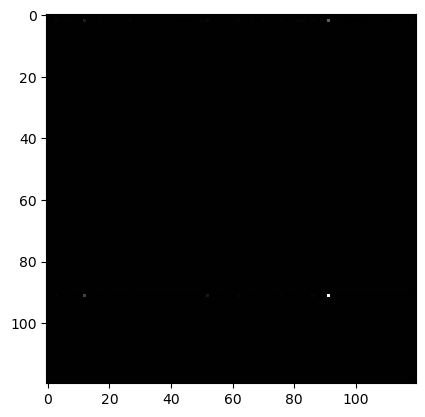

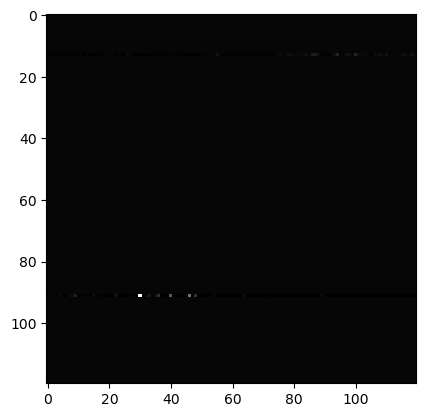

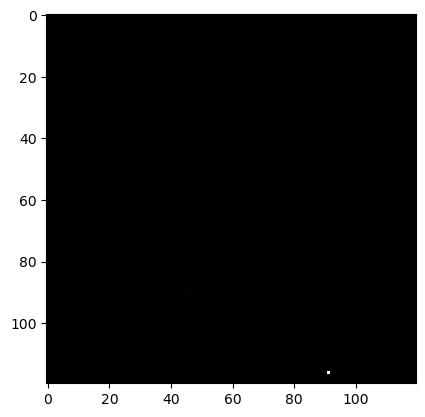

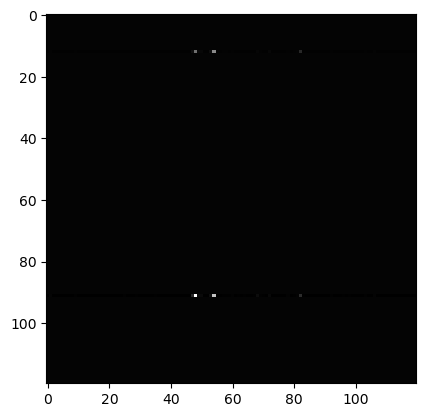

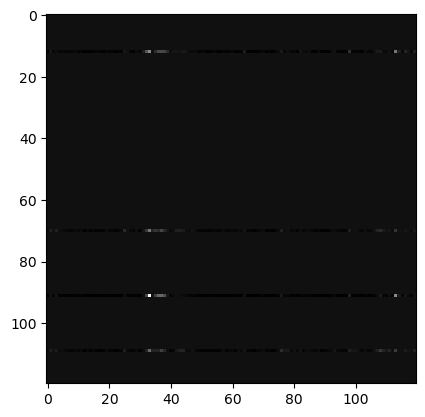

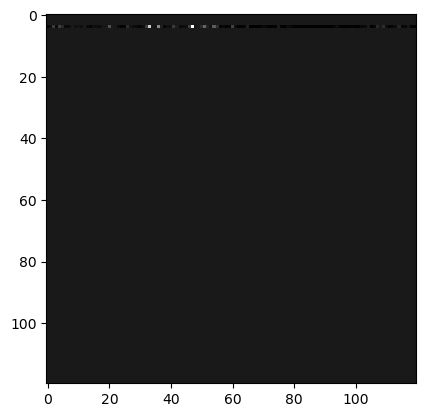

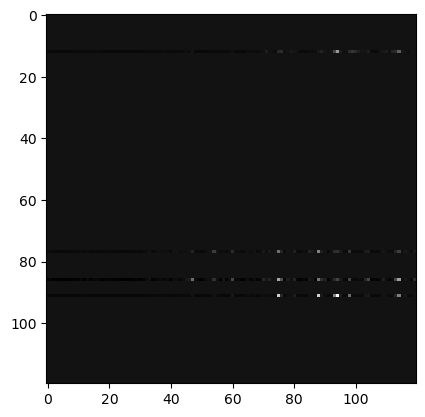

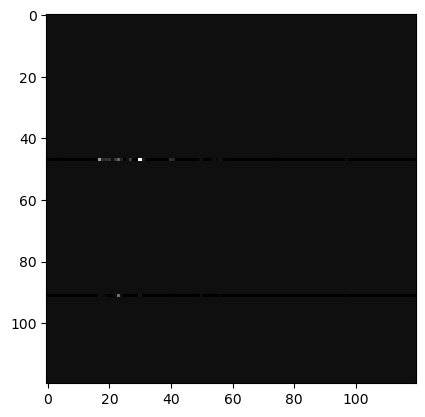

In [ ]:
import cv2


def img_resize(image):
    height, width = image.shape[0], image.shape[1]
    # 设置新的图片分辨率框架
    width_new = 120
    height_new = 120
    # 判断图片的长宽比率
    if width / height >= width_new / height_new:
        img_new = cv2.resize(image, (width_new, int(height * width_new / width)))
    else:
        img_new = cv2.resize(image, (int(width * height_new / height), height_new))
    return img_new

for i in range(8):
    img = attn[0, i, :, :].cpu().detach().numpy() * 255
    img_new = img_resize(img) / 255
    plt.imshow(img_new, cmap='viridis')
    plt.show()

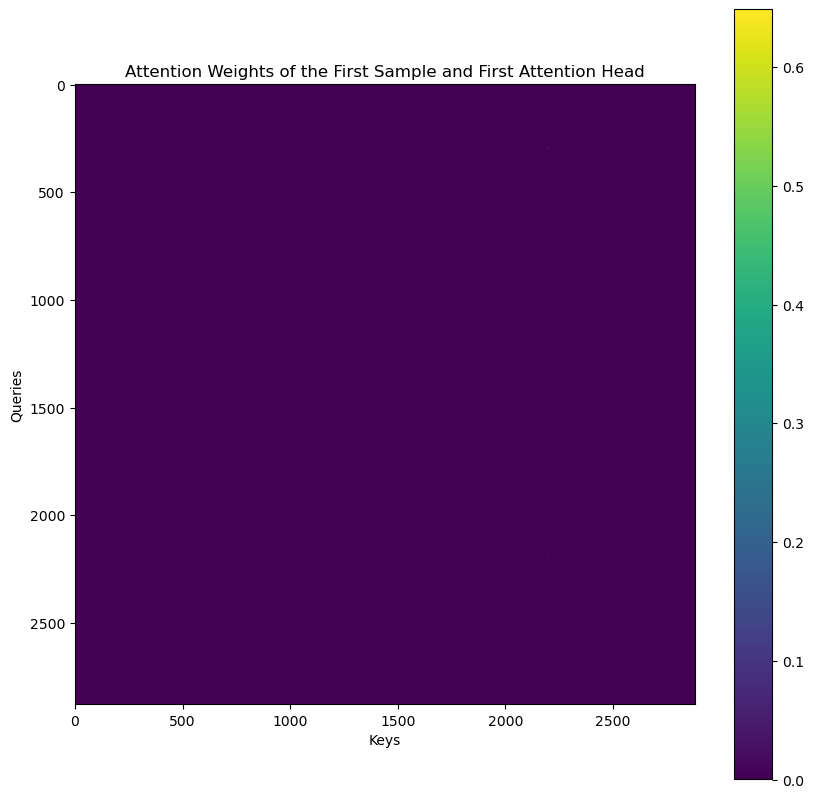

In [ ]:
import matplotlib.pyplot as plt
import torch

# 假设 attn 是你打印出来的注意力权重张量，形状为 [18, 8, 2880, 2880]
# 为了演示，我们这里随机生成一个这样的张量
# attn = torch.rand(18, 8, 2880, 2880)

# 选择第一个批次和第一个注意力头的注意力权重
attn_to_plot = attn[0, 2, :, :].cpu().detach().numpy()

# 使用 Matplotlib 进行可视化
plt.figure(figsize=(10, 10))
plt.imshow(attn[0,0,:, :].cpu().detach().numpy(), cmap='viridis')
plt.colorbar()
plt.title("Attention Weights of the First Sample and First Attention Head")
plt.xlabel("Keys")
plt.ylabel("Queries")
plt.show()
